In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from math import sqrt
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

from helper import series_to_supervised
from model.mlp import mlp_layer

2024-01-10 12:27:33.031905: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
dataset = pd.read_csv('../../data/energy_weather.csv', index_col=0)
# https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather

dataset.fillna(0, inplace=True)
data = dataset
data

,price,price_dayahead,gen_coal,gen_gas,load_actual,gen_lig,gen_oil,gen_oth_renew,pressure_Barcelona,pressure_Bilbao,...,wind_deg_Bilbao,clouds_all_Bilbao,gen_hyd_river,wind_deg_Seville,wind_speed_Barcelona,wind_speed_Valencia,wind_speed_Bilbao,gen_wind,wind_speed_Madrid,gen_hyd_pump
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,64.92,48.10,4755.0,5196.0,24382.0,328.0,158.0,71.0,1035.0,1035.0,...,229.0,0.0,1009.0,21.0,7.0,1.0,0.0,5890.0,1.0,920.0
2015-01-01 01:00:00+00:00,64.48,47.33,4581.0,4857.0,22734.0,323.0,157.0,73.0,1036.0,1036.0,...,224.0,0.0,973.0,27.0,7.0,0.0,1.0,5461.0,1.0,1164.0
2015-01-01 02:00:00+00:00,59.32,42.27,4131.0,4314.0,21286.0,254.0,160.0,75.0,1036.0,1035.0,...,225.0,0.0,949.0,27.0,7.0,0.0,1.0,5238.0,1.0,1503.0
2015-01-01 03:00:00+00:00,56.04,38.41,3840.0,4130.0,20264.0,187.0,156.0,74.0,1036.0,1035.0,...,221.0,0.0,953.0,27.0,7.0,0.0,1.0,4935.0,1.0,1826.0
2015-01-01 04:00:00+00:00,53.63,35.72,3590.0,4038.0,19905.0,178.0,156.0,74.0,1037.0,1035.0,...,224.0,0.0,952.0,57.0,5.0,2.0,1.0,4618.0,0.0,2109.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,77.02,68.85,2628.0,7634.0,30653.0,0.0,178.0,95.0,1027.0,1033.0,...,57.0,0.0,1135.0,30.0,1.0,2.0,0.0,3113.0,1.0,1.0
2018-12-31 19:00:00+00:00,76.16,68.40,2566.0,7241.0,29735.0,0.0,174.0,95.0,1027.0,1034.0,...,0.0,0.0,1172.0,30.0,3.0,1.0,1.0,3288.0,1.0,1.0
2018-12-31 20:00:00+00:00,74.30,66.88,2422.0,7025.0,28071.0,0.0,168.0,94.0,1028.0,1034.0,...,140.0,0.0,1148.0,50.0,4.0,3.0,1.0,3503.0,1.0,50.0


In [5]:
data.columns

Index(['price', 'price_dayahead', 'gen_coal', 'gen_gas', 'load_actual',
       'gen_lig', 'gen_oil', 'gen_oth_renew', 'pressure_Barcelona',
       'pressure_Bilbao', 'gen_waste', 'gen_bio', 'temp_min_Valencia',
       'pressure_Valencia', 'temp_min_Barcelona', 'humidity_Seville',
       'wind_deg_Bilbao', 'clouds_all_Bilbao', 'gen_hyd_river',
       'wind_deg_Seville', 'wind_speed_Barcelona', 'wind_speed_Valencia',
       'wind_speed_Bilbao', 'gen_wind', 'wind_speed_Madrid', 'gen_hyd_pump'],
      dtype='object')

### Preprocess

In [37]:
values = data.values

# specify the number of lag hours
n_hours = 24*3
n_features = data.shape[-1]
k = 12
split1 = 0.7
split2 = 0.85

# frame as supervised learning
reframed = series_to_supervised(values, n_hours, k)
print("reframed.shape:", reframed.shape)

reframed.shape: (34980, 2184)


In [38]:
# split into train and test sets
reframed_values = reframed.values
n_train_hours = int(len(reframed_values)*split1)
n_valid_hours = int(len(reframed_values)*split2)

train = reframed_values[:n_train_hours, :]
val = reframed_values[n_train_hours:n_valid_hours, :]
test = reframed_values[n_valid_hours:, :]


# split into input and outputs
n_obs = n_hours * n_features
feature_idx = 0
train_X, train_y = train[:, :n_obs], train[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
val_X, val_y = val[:, :n_obs], val[:, [n_obs + feature_idx + n_features * i for i in range(k)]]
test_X, test_y = test[:, :n_obs], test[:, [n_obs + feature_idx + n_features * i for i in range(k)]]


print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (24486, 1872) (24486, 12) (5247, 1872) (5247, 12) (5247, 1872) (5247, 12)


In [39]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)

val_X = scaler.fit_transform(val_X)
val_y = scaler.fit_transform(val_y)

test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
val_X = val_X.reshape((val_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))

print("train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape", 
      train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape
     )

train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape (24486, 72, 26) (24486, 12) (5247, 72, 26) (5247, 12) (5247, 72, 26) (5247, 12)


### PM threshold

In [40]:
train_X_pm = train_X[:, 0, feature_idx]
print(train_X_pm.shape)

val_X_pm = val_X[:, 0, feature_idx]
print(val_X_pm.shape)

test_X_pm = test_X[:, 0, feature_idx]
print(test_X_pm.shape)

(24486,)
(5247,)
(5247,)


In [41]:
bin_nums = 20

# Step 1: Calculate the histogram
counts, bin_edges = np.histogram(train_X_pm, bins=bin_nums)

# Step 2: Invert counts to assign lower weights to more frequent bins, avoid division by zero by adding a small number (epsilon)
epsilon = 1e-8
weights = np.sqrt(1.0 / (counts + epsilon))
# weights = 1.0 / (counts + epsilon)

# Step 3: Normalize the weights (optional)
# weights /= np.max(weights)
weights /= np.sum(weights) * len(counts)

# Step 4: Assign weights to each sample based on the bin it falls into
sample_weights = np.zeros(train_X_pm.shape[0])

for i, value in enumerate(train_X_pm):
    
    # Find the index of the bin this sample falls into
    bin_index = np.digitize(value, bin_edges) - 1
    bin_index = min(bin_index, bin_nums - 1)
    
    # Assign the corresponding weight
    sample_weights[i] = weights[bin_index]

In [42]:
sample_weights.shape

(24486,)

In [43]:
# sample_weights /= np.sum(sample_weights)
# sample_weights /= np.max(sample_weights)
# sample_weights = (sample_weights - sample_weights.min()) / (sample_weights.max()-sample_weights.min()) + 0.1

(array([1.9942e+04, 2.6140e+03, 1.2390e+03, 2.7200e+02, 1.6500e+02,
        0.0000e+00, 0.0000e+00, 1.5100e+02, 5.4000e+01, 0.0000e+00,
        3.7000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2000e+01]),
 array([0.00057706, 0.0010838 , 0.00159055, 0.00209729, 0.00260403,
        0.00311078, 0.00361752, 0.00412427, 0.00463101, 0.00513775,
        0.0056445 , 0.00615124, 0.00665798, 0.00716473, 0.00767147,
        0.00817822, 0.00868496, 0.0091917 , 0.00969845, 0.01020519,
        0.01071193]),
 <BarContainer object of 20 artists>)

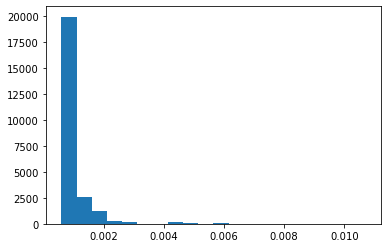

In [44]:
plt.hist(sample_weights, bins=20)

In [49]:
np.save('sample_weights_price_IPF.npy', sample_weights)

### Model

In [46]:
# ===== model parameters ======
mlp_unit1 = 128
mlp_unit2 = 128
mlp_unit3 = 64
mlp_unit4 = 64
mlp_unit5 = 32
mlp_unit6 = 32
mlp_unit7 = 16
mlp_unit8 = 16
dropout = 0.0
kernel_size = 2
pool_size = 2
learning_rate = 1e-4
decay_steps = 10000
decay_rate = 0.95
PATIENCE = 100
EPOCHS = 1000
BATCH = 512
opt_num = k
input_shape = train_X.shape[1:]

In [47]:
model = mlp_layer(input_shape=input_shape,
                   mlp_unit1=mlp_unit1,
                   mlp_unit2=mlp_unit2,
                   mlp_unit3=mlp_unit3,
                   mlp_unit4=mlp_unit4,
                   mlp_unit5=mlp_unit5,
                   mlp_unit6=mlp_unit6,
                   mlp_unit7=mlp_unit7,
                   mlp_unit8=mlp_unit8,
                   dropout=dropout,
                   masked_value=-1,
                   opt_num=opt_num
                  )
# model.summary()

In [48]:
model.compile(optimizer='adam',
#               loss=custom_weight_loss,
              loss='mse',
              metrics=['mae']
             )

es = EarlyStopping(monitor='val_mae', mode='min', verbose=2, patience=PATIENCE)
mc = ModelCheckpoint('../../saved_models/price_all_weighted_IPF_95.h5', 
                     monitor='val_mae', 
                     mode='min', 
                     verbose=2, 
                     save_best_only=True,
                    )


model.fit(train_X, train_y,
          validation_data=(val_X, val_y),
          epochs=EPOCHS,
          batch_size=BATCH,
          verbose=2,
          shuffle=True,
          callbacks=[es, mc],
          sample_weight=sample_weights
         )

Epoch 1/1000
48/48 - 2s - loss: 4.6506e-05 - mae: 0.1639 - val_loss: 0.0144 - val_mae: 0.0943

Epoch 00001: val_mae improved from inf to 0.09432, saving model to ../../saved_models/energy_all_weighted_IPF_95.h5
Epoch 2/1000
48/48 - 1s - loss: 1.2088e-05 - mae: 0.0848 - val_loss: 0.0140 - val_mae: 0.0888

Epoch 00002: val_mae improved from 0.09432 to 0.08879, saving model to ../../saved_models/energy_all_weighted_IPF_95.h5
Epoch 3/1000
48/48 - 1s - loss: 9.2641e-06 - mae: 0.0763 - val_loss: 0.0131 - val_mae: 0.0853

Epoch 00003: val_mae improved from 0.08879 to 0.08526, saving model to ../../saved_models/energy_all_weighted_IPF_95.h5
Epoch 4/1000
48/48 - 1s - loss: 8.0349e-06 - mae: 0.0714 - val_loss: 0.0122 - val_mae: 0.0824

Epoch 00004: val_mae improved from 0.08526 to 0.08245, saving model to ../../saved_models/energy_all_weighted_IPF_95.h5
Epoch 5/1000
48/48 - 1s - loss: 6.8183e-06 - mae: 0.0655 - val_loss: 0.0080 - val_mae: 0.0675

Epoch 00005: val_mae improved from 0.08245 to 0.0


Epoch 00048: val_mae did not improve from 0.04869
Epoch 49/1000
48/48 - 1s - loss: 1.9506e-06 - mae: 0.0358 - val_loss: 0.0049 - val_mae: 0.0527

Epoch 00049: val_mae did not improve from 0.04869
Epoch 50/1000
48/48 - 1s - loss: 1.9357e-06 - mae: 0.0357 - val_loss: 0.0048 - val_mae: 0.0519

Epoch 00050: val_mae did not improve from 0.04869
Epoch 51/1000
48/48 - 1s - loss: 1.9036e-06 - mae: 0.0355 - val_loss: 0.0047 - val_mae: 0.0513

Epoch 00051: val_mae did not improve from 0.04869
Epoch 52/1000
48/48 - 1s - loss: 1.8603e-06 - mae: 0.0351 - val_loss: 0.0045 - val_mae: 0.0499

Epoch 00052: val_mae did not improve from 0.04869
Epoch 53/1000
48/48 - 1s - loss: 1.8795e-06 - mae: 0.0354 - val_loss: 0.0046 - val_mae: 0.0503

Epoch 00053: val_mae did not improve from 0.04869
Epoch 54/1000
48/48 - 1s - loss: 1.9189e-06 - mae: 0.0358 - val_loss: 0.0046 - val_mae: 0.0506

Epoch 00054: val_mae did not improve from 0.04869
Epoch 55/1000
48/48 - 1s - loss: 1.8964e-06 - mae: 0.0356 - val_loss: 0.0

48/48 - 1s - loss: 9.8960e-07 - mae: 0.0266 - val_loss: 0.0062 - val_mae: 0.0592

Epoch 00105: val_mae did not improve from 0.04869
Epoch 106/1000
48/48 - 1s - loss: 9.5624e-07 - mae: 0.0261 - val_loss: 0.0064 - val_mae: 0.0601

Epoch 00106: val_mae did not improve from 0.04869
Epoch 107/1000
48/48 - 1s - loss: 9.9436e-07 - mae: 0.0267 - val_loss: 0.0065 - val_mae: 0.0609

Epoch 00107: val_mae did not improve from 0.04869
Epoch 108/1000
48/48 - 1s - loss: 9.4203e-07 - mae: 0.0259 - val_loss: 0.0064 - val_mae: 0.0607

Epoch 00108: val_mae did not improve from 0.04869
Epoch 109/1000
48/48 - 1s - loss: 9.7037e-07 - mae: 0.0263 - val_loss: 0.0066 - val_mae: 0.0615

Epoch 00109: val_mae did not improve from 0.04869
Epoch 110/1000
48/48 - 1s - loss: 1.0108e-06 - mae: 0.0269 - val_loss: 0.0068 - val_mae: 0.0628

Epoch 00110: val_mae did not improve from 0.04869
Epoch 111/1000
48/48 - 1s - loss: 9.1881e-07 - mae: 0.0256 - val_loss: 0.0067 - val_mae: 0.0623

Epoch 00111: val_mae did not improve

48/48 - 1s - loss: 6.3074e-07 - mae: 0.0212 - val_loss: 0.0077 - val_mae: 0.0668

Epoch 00161: val_mae did not improve from 0.04869
Epoch 162/1000
48/48 - 1s - loss: 6.5116e-07 - mae: 0.0216 - val_loss: 0.0080 - val_mae: 0.0680

Epoch 00162: val_mae did not improve from 0.04869
Epoch 163/1000
48/48 - 1s - loss: 6.4236e-07 - mae: 0.0214 - val_loss: 0.0080 - val_mae: 0.0681

Epoch 00163: val_mae did not improve from 0.04869
Epoch 164/1000
48/48 - 1s - loss: 6.2001e-07 - mae: 0.0210 - val_loss: 0.0081 - val_mae: 0.0682

Epoch 00164: val_mae did not improve from 0.04869
Epoch 165/1000
48/48 - 1s - loss: 6.0544e-07 - mae: 0.0208 - val_loss: 0.0082 - val_mae: 0.0688

Epoch 00165: val_mae did not improve from 0.04869
Epoch 166/1000
48/48 - 1s - loss: 5.8750e-07 - mae: 0.0205 - val_loss: 0.0084 - val_mae: 0.0700

Epoch 00166: val_mae did not improve from 0.04869
Epoch 167/1000
48/48 - 1s - loss: 6.2208e-07 - mae: 0.0210 - val_loss: 0.0082 - val_mae: 0.0688

Epoch 00167: val_mae did not improve

48/48 - 1s - loss: 5.2504e-07 - mae: 0.0193 - val_loss: 0.0095 - val_mae: 0.0743

Epoch 00217: val_mae did not improve from 0.04869
Epoch 218/1000
48/48 - 1s - loss: 4.4192e-07 - mae: 0.0177 - val_loss: 0.0095 - val_mae: 0.0745

Epoch 00218: val_mae did not improve from 0.04869
Epoch 219/1000
48/48 - 1s - loss: 4.5962e-07 - mae: 0.0181 - val_loss: 0.0096 - val_mae: 0.0751

Epoch 00219: val_mae did not improve from 0.04869
Epoch 220/1000
48/48 - 1s - loss: 4.6299e-07 - mae: 0.0181 - val_loss: 0.0098 - val_mae: 0.0760

Epoch 00220: val_mae did not improve from 0.04869
Epoch 221/1000
48/48 - 1s - loss: 4.7001e-07 - mae: 0.0182 - val_loss: 0.0097 - val_mae: 0.0750

Epoch 00221: val_mae did not improve from 0.04869
Epoch 222/1000
48/48 - 1s - loss: 4.6811e-07 - mae: 0.0182 - val_loss: 0.0093 - val_mae: 0.0738

Epoch 00222: val_mae did not improve from 0.04869
Epoch 223/1000
48/48 - 1s - loss: 4.4235e-07 - mae: 0.0177 - val_loss: 0.0098 - val_mae: 0.0759

Epoch 00223: val_mae did not improve